In [ ]:
!pip install sklearn --upgrade
!pip install joblib
# Data preprocessing, math and plotting
import os
import numpy as np 
import pandas as pd 
from scipy import stats 
import matplotlib.pyplot as plt
import seaborn as sns 

# ML 
import sklearn
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.metrics import r2_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import datetime
import random



In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

df_item = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_order_items_dataset.csv") ## used
df_reviews = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_order_reviews_dataset.csv") ## used
df_orders = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_orders_dataset.csv")
df_products = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_products_dataset.csv") ## used
df_geolocation = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_geolocation_dataset.csv")
df_sellers = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_sellers_dataset.csv") ## used
df_order_pay = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_order_payments_dataset.csv") ## used
df_customers = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_customers_dataset.csv") ## used
df_category = pd.read_csv("gdrive/My Drive/brazil_ecommerce/olist_product_category_name_translation.csv") ## used


In [ ]:
# merge all the dataframes created from each of the csv files 
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_reviews, on='order_id', how='outer')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_customers, on='customer_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')
df_train = df_train.merge(df_category, on='product_category_name', how='outer')

df_train.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,payment_sequential,payment_type,payment_installments,payment_value,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,1.0,credit_card,1.0,18.12,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,housewares
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,3.0,voucher,1.0,2.00,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,housewares
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-10-06 11:07:15,29.99,8.72,2.0,voucher,1.0,18.59,a54f0611adc9ed256b57ede6b6eb5114,4,NaN,"Não testei o produto ainda, mas ele veio corre...",2017-10-11 00:00:00,2017-10-12 03:43:48,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,9350.0,maua,SP,housewares
3,128e10d95713541c87cd1a2e48201934,a20e8105f23924cd00833fd87daa0831,delivered,2017-08-15 18:29:31,2017-08-15 20:05:16,2017-08-17 15:28:33,2017-08-18 14:44:43,2017-08-28 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-21 20:05:16,29.99,7.78,1.0,credit_card,3.0,37.77,b46f1e34512b0f4c74a72398b03ca788,4,NaN,Deveriam embalar melhor o produto. A caixa vei...,2017-08-19 00:00:00,2017-08-20 15:16:36,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,3a51803cc0d012c3b5dc8b7528cb05f7,3366,sao paulo,SP,9350.0,maua,SP,housewares
4,0e7e841ddf8f8f2de2bad69267ecfbcf,26c7ac168e1433912a51b924fbd34d34,delivered,2017-08-02 18:24:47,2017-08-02 18:43:15,2017-08-04 17:35:43,2017-08-07 18:30:01,2017-08-15 00:00:00,1.0,87285b34884572647811a353c7ac498a,3504c0cb71d7fa48d967e0e4c94d59d9,2017-08-08 18:37:31,29.99,7.78,1.0,credit_card,1.0,37.77,dc90f19c2806f1abba9e72ad3c350073,5,NaN,"Só achei ela pequena pra seis xícaras ,mais é ...",2017-08-08 00:00:00,2017-08-08 23:26:23,utilidades_domesticas,40.0,268.0,4.0,500.0,19.0,8.0,13.0,ef0996a1a279c26e7ecbd737be23d235,2290,sao paulo,SP,9350.0,maua,SP,housewares


In [ ]:
# show column headers
df_train.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'product_category_name_english'],
      dtype='object')

In [ ]:
# drop columns that are not necessary for recommendation system 
df_train = df_train.drop(['order_id','order_status', 'order_purchase_timestamp',
                          'order_approved_at', 'order_delivered_carrier_date',
                          'order_delivered_customer_date','order_estimated_delivery_date',
                          'order_item_id','seller_id','shipping_limit_date','payment_sequential',
                          'payment_type','payment_installments','review_id','review_comment_title',
                          'review_comment_message','review_creation_date','review_answer_timestamp',
                          'product_category_name','customer_unique_id','customer_zip_code_prefix'], axis=1)

df_train.head()

,customer_id,product_id,price,freight_value,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,product_category_name_english
0,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,18.12,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP,housewares
1,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,2.00,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP,housewares
2,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,18.59,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP,housewares
3,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99,7.78,37.77,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP,housewares
4,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,29.99,7.78,37.77,5,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP,housewares


In [ ]:
# move last column element to the first element of the dataframe 
cols = df_train.columns.tolist()
cols = cols[-1:] + cols[:-1]
df_train = df_train[cols]
df_train.head()

,product_category_name_english,customer_id,product_id,price,freight_value,payment_value,review_score,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state
0,housewares,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,18.12,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP
1,housewares,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,2.00,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP
2,housewares,9ef432eb6251297304e76186b10a928d,87285b34884572647811a353c7ac498a,29.99,8.72,18.59,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP
3,housewares,a20e8105f23924cd00833fd87daa0831,87285b34884572647811a353c7ac498a,29.99,7.78,37.77,4,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP
4,housewares,26c7ac168e1433912a51b924fbd34d34,87285b34884572647811a353c7ac498a,29.99,7.78,37.77,5,40.0,268.0,4.0,500.0,19.0,8.0,13.0,sao paulo,SP,9350.0,maua,SP


In [ ]:
# count unique occurence of product categories in dataframe
df_train['product_category_name_english'].value_counts()

bed_bath_table               11990
health_beauty                10033
sports_leisure                9005
furniture_decor               8833
computers_accessories         8151
                             ...  
arts_and_craftmanship           24
la_cuisine                      16
cds_dvds_musicals               14
fashion_childrens_clothes        8
security_and_services            2
Name: product_category_name_english, Length: 71, dtype: int64

In [ ]:
# view the minimum value, maximum value, counts and number of unique values
df_train.groupby('product_category_name_english').agg(['min','max','count','nunique']).reset_index(drop=False)

product_category_name_english  ... seller_state
                                  ...      nunique
0     agro_industry_and_commerce  ...            7
1               air_conditioning  ...            9
2                            art  ...            8
3          arts_and_craftmanship  ...            5
4                          audio  ...            7
..                           ...  ...          ...
66                    stationery  ...            9
67        tablets_printing_image  ...            2
68                     telephony  ...           12
69                          toys  ...           11
70                 watches_gifts  ...           10

[71 rows x 73 columns]

In [ ]:
# show top ten most popular categories
df_popular_categories = pd.DataFrame(df_train.groupby('product_category_name_english')['review_score'].count())
most_popular_categories = df_popular_categories.sort_values('review_score', ascending=False)
most_popular_categories.head(10)

,review_score
product_category_name_english,
bed_bath_table,11990
health_beauty,10033
sports_leisure,9005
furniture_decor,8833
computers_accessories,8151
housewares,7380
watches_gifts,6213
telephony,4726
garden_tools,4590


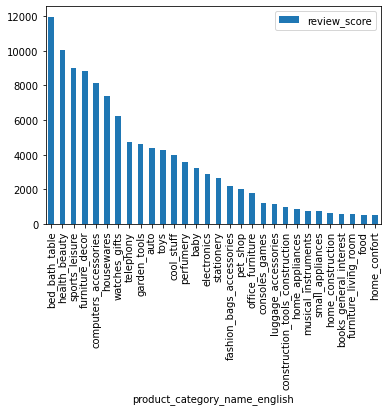

In [ ]:
 # show the 30 most popular item categories 
most_popular_categories.head(30).plot(kind = "bar")

In [ ]:
# show top ten most popular items
df_popular_items = pd.DataFrame(df_train.groupby('product_id')['review_score'].count())
most_popular_items = df_popular_items.sort_values('review_score', ascending=False)
most_popular_items.head(10)

,review_score
product_id,
aca2eb7d00ea1a7b8ebd4e68314663af,536
99a4788cb24856965c36a24e339b6058,528
422879e10f46682990de24d770e7f83d,508
389d119b48cf3043d311335e499d9c6b,406
368c6c730842d78016ad823897a372db,398
53759a2ecddad2bb87a079a1f1519f73,391
d1c427060a0f73f6b889a5c7c61f2ac4,357
53b36df67ebb7c41585e8d54d6772e08,327
154e7e31ebfa092203795c972e5804a6,295


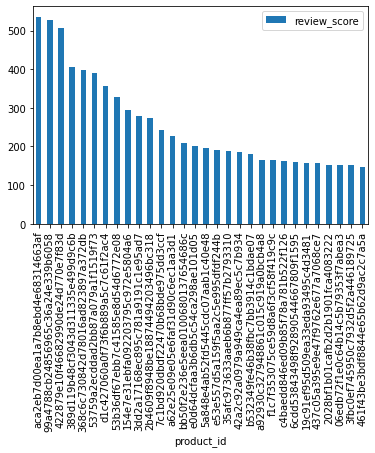

In [ ]:
most_popular_items.head(30).plot(kind = "bar")

In [ ]:
# Model-based collaborative filtering system
## Recommend items to users based on purchase history and similarity of ratings provided by other users who bought items to that of a particular customer.
### A model based collaborative filtering technique is closen here as it helps in making predictinfg products for a particular user by identifying patterns based on preferences from multiple user data.

# Utility Matrix based on products sold and user reviews
## An utlity matrix is consists of all possible user-item preferences (ratings) details represented as a matrix. 
### The utility matrix is sparce as none of the users would buy all teh items in the list, hence, most of the values are unknown.

# subset of dataset 'df_train'
df_train_subset = df_train.head(10000)

df_train_util_matrix = df_train_subset.pivot_table(values='review_score', index='customer_id', columns='product_id', fill_value=0)
df_train_util_matrix.head()

# transpose the matrix 
X = df_train_util_matrix.T
X.head()

# unique products in subset of data
X1 = X

In [ ]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2971, 10)

In [ ]:
# Correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(2971, 2971)

In [ ]:
# Isolating Product ID # 00250175f79f584c14ab5cecd80553cd from the Correlation Matrix (random selection based on index value[1])
X.index[1]

'00250175f79f584c14ab5cecd80553cd'

In [ ]:
# Index number and product ID purchased by customer 
i = '00250175f79f584c14ab5cecd80553cd'

product_names = list(X.index)
product_id = product_names.index(i)
product_id

1

In [ ]:
# Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product
correlation_product_ID = correlation_matrix[product_id]
correlation_product_ID.shape

(2971,)

In [ ]:
# Recommending the most highly correlated products in sequence with scores of over 0.90
Recommend = list(X.index[correlation_product_ID > 0.90])

 # removes the item already bought by the customer 
Recommend.remove(i) 
Recommend

# Below are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website. (only if we knew what each product ID represented....)

['0259ef48d9c5f59c3b31147c52db801d',
 '05eee88d9d208fa34d4246aae4025381',
 '07e1dae59ffce9e47d0f529361d492f6',
 '090d6db6ad440d35cef0726b5a8bec14',
 '0b8d94b0bcf4e22c9bf886c98bb994d3',
 '0c0caad13e2d2bf4efb9856075ad1120',
 '1ac5b02a81e28c27713b7229144a773e',
 '1cd7f362c94c8a3a854103a8da2d8f43',
 '20531b0644a0719b8d506c4db3c56609',
 '21fd3b391a97c2fedab9d0efdd183a93',
 '2804f6c4f96a5c917461534b63faf357',
 '29781581fb82fe2389560a3a5331d0ee',
 '2d36fe5f546a2a0d9cf193511d2a916f',
 '30a47cc354b9607076272300c899dce9',
 '30d55419015a4d9c2ca68586923d5a9f',
 '367dd13835e78ce371a3e7ed449a1d26',
 '36df104745cb6dd332bd1eff627af709',
 '37933ba010cb5d5f231585d26287bed3',
 '42e3fe954b8179e5a4fb431d40662419',
 '49949e69181c88f76527f613550ca6f6',
 '4d8c2f14df6a1429692e995d787613a5',
 '507e1658812a4451005d2ff5a09ccd6d',
 '57e089e3103f5cda6a4ce23b77399bdb',
 '5a3f2f6e363dcc2277ba8df88f3a078c',
 '5ccdf90770b6368962f99d5bdccb7ef1',
 '8a9e6069daf723d19d2f3644f30a0045',
 '8bbc072e9ad5dfad286bf7965b945217',
 